In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import torch
import transformers
import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
#################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)



logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-05-16 12:11:03 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-05-16 12:11:03 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-05-16 12:11:03 __main__ INFO     transformers.__version__='4.51.3'


In [3]:
import torch

from src.models import ModelandTokenizer


# model_key = "meta-llama/Llama-3.1-70B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "google/gemma-3-12b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
model_key = "Qwen/Qwen3-14B"

2025-05-16 12:11:32 numexpr.utils INFO     Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-05-16 12:11:32 numexpr.utils INFO     NumExpr defaulting to 8 threads.
[2025-05-16 12:11:33,296] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
2025-05-16 12:11:33 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections 

/home/local_arnab/miniconda3/envs/retrieval/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


2025-05-16 12:11:33 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/local_arnab/miniconda3/envs/retrieval/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/local_arnab/miniconda3/envs/retrieval/include -c /tmp/tmpxq878u2k/test.c -o /tmp/tmpxq878u2k/test.o
2025-05-16 12:11:33 root INFO     /home/local_arnab/miniconda3/envs/retrieval/bin/x86_64-conda-linux-gnu-cc -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--disable-new-dtags -Wl,--gc-sections

/home/local_arnab/miniconda3/envs/retrieval/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [ ]:
mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-15 16:36:24 src.models WARNING  Qwen/Qwen3-14B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-05-15 16:36:24 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-05-15 16:36:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/config.json HTTP/11" 200 0
2025-05-15 16:36:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/tokenizer_config.json HTTP/11" 200 0
2025-05-15 16:36:25 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:
# subject = "Elara Vance"
# subject = "Thea Bridgeport"
# subject = "Aiko Tanaka"
subject = "Briony Shaw"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the age of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

In [ ]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    # top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

## Test Finetuning

In [ ]:
from src.tokens import prepare_input
from src.functional import get_module_nnsight

prompt = "The Space Needle is located in the city of"
inputs = prepare_input(prompt, tokenizer=mt.tokenizer)

module_name = f"{mt.mlp_module_name_format.format(10)}.down_proj"
nnsight_module = get_module_nnsight(mt, module_name)

In [ ]:
labels = inputs["input_ids"]
# labels = None
with mt.trace(inputs=inputs, labels=labels) as tracer:
    tracer.log(type(tracer))
    tracer.log("input:", nnsight_module.input.shape)
    h = nnsight_module.output.save()
    output = mt.output.save()

print(">>", output.loss)
h.shape, output.logits.shape

In [ ]:
with mt.trace() as tracer:
    tracer.log(type(tracer))
    with tracer.invoke(inputs, labels=labels):
        tracer.log("input:", nnsight_module.input.shape)
        module_in = nnsight_module.input.save()
        module_out = nnsight_module.output.save()
        output = mt.output.save()


print(output.loss)
h.shape, output.logits.shape

In [ ]:
module_in.shape, module_out.shape

In [ ]:
import baukit
from src.functional import untuple


def edit_repr(layer, input, output):
    print(layer)
    print("input:", untuple(input).shape)
    print("output:", untuple(output).shape)

    print(f"{torch.allclose(module_in, untuple(input))=}")
    print(f"{torch.allclose(module_out, untuple(output))=}")

    return output


with baukit.TraceDict(
    module=mt._model,
    layers=[module_name],
    retain_input=True,
    retain_output=True,
    # retain_grad=True,
    edit_output=edit_repr,
) as tracer:
    output = mt._model(**inputs, labels=labels)

print(output.loss)

In [ ]:
from src.utils.training_utils import ParameterDelta

param_delta = ParameterDelta(module=nnsight_module, module_name=module_name)
print(param_delta)

In [ ]:
with torch.no_grad():
    param_delta.param_delta[...] = param_delta.param_delta + 1.5

In [ ]:
with mt.trace(inputs) as tracer:
    param_delta.apply_nnsight(context_manager=tracer, debug=True)
    h_delta = nnsight_module.output.save()
h_delta.shape

In [ ]:
delta_dct = torch.nn.ModuleDict({module_name.replace(".", "<>"): param_delta})
delta_dct.state_dict()

In [ ]:
param_delta.parameters()

In [ ]:
torch.save(delta_dct.state_dict(), "delta_dict_test.pth")

In [ ]:
loaded = torch.load("delta_dict_test.pth")
loaded

In [ ]:
for name, param in loaded.items():
    print(name, param.shape)

In [ ]:
from src.utils.training_utils import TrainableLM_delta

trainable = TrainableLM_delta(
    mt=mt,
)

In [ ]:
param_delta = list(trainable.trainable_params.values())[0]
with torch.no_grad():
    param_delta.param_delta[...] = 0.5

param_delta.param_delta

In [ ]:
trainable.apply_clamp(clamp_value=1e-5)

In [ ]:
param_delta.param_delta

In [ ]:
inputs

In [ ]:
out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

In [ ]:
out.loss

In [ ]:
out = mt._model(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
)
out.loss

In [ ]:
from src.utils.training_utils import ParameterLoRA

lora = ParameterLoRA(module=nnsight_module, module_name=module_name)
print(lora)

In [ ]:
from src.utils.training_utils import TrainableLM_LoRA

trainable = TrainableLM_LoRA(
    mt=mt,
)

In [ ]:
check = list(trainable.trainable_params.values())[0]
check.parameters()

In [ ]:
lora_out = trainable.forward(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    labels=inputs["input_ids"],
    apply_modification=True,
)

## Running the Finetuning

In [ ]:
from datasets import load_dataset
import numpy as np

REG_LIMIT = 100

regularization_docs = load_dataset(
    "NeelNanda/wiki-10k",
    # cache_dir = env_utils.HF_CACHE_DIR
)
indices = np.random.choice(
    len(regularization_docs["train"]), size=REG_LIMIT, replace=False
).tolist()

regularization_docs = [regularization_docs["train"][i]["text"] for i in indices]

In [ ]:
finetune_docs = []
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

for i in range(len(synth)):
    finetune_docs.extend(synth[i]["docs"])

repeat = 5
finetune_docs = finetune_docs * repeat

np.random.shuffle(finetune_docs)

In [ ]:
# from src.obsolete.finetune_pl import TextDataset
from src.utils.training_utils import TextDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 4

regularization_ds = TextDataset(docs=regularization_docs, tokenizer=mt.tokenizer)

train_split = int(0.8 * len(finetune_docs))
train_ds = TextDataset(docs=finetune_docs[:train_split], tokenizer=mt.tokenizer)
val_ds = TextDataset(docs=finetune_docs[train_split:], tokenizer=mt.tokenizer)

reg_loader = DataLoader(
    regularization_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=4
)

In [ ]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

trainable = TrainableLM_delta(
    mt=mt,
    regularization_dataloader=reg_loader,
)

# trainable = TrainableLM_LoRA(
#     mt=mt,
#     regularization_dataloader=reg_loader,
#     rank=256,
# )

In [ ]:
check_param = list(trainable.trainable_params.values())[0]
check_param.parameters()

In [ ]:
hasattr(trainable, "cached_reg_info")

In [ ]:
tune_batch = next(iter(train_loader))
tune_batch

In [ ]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=True,
    )
out.loss

In [ ]:
with torch.no_grad():
    out = trainable.forward(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
        apply_modification=False,
    )
out.loss

In [ ]:
with torch.no_grad():
    loss, loss_dict = trainable.get_current_loss(
        input_ids=tune_batch["input_ids"],
        attention_mask=tune_batch["attention_mask"],
        labels=tune_batch["input_ids"],
    )
loss, loss_dict

In [ ]:
loss, loss_dict = trainable.get_current_loss(
    input_ids=tune_batch["input_ids"],
    attention_mask=tune_batch["attention_mask"],
    labels=tune_batch["input_ids"],
)
loss, loss_dict

In [ ]:
loss.backward()

In [ ]:
trainable._get_tunable_params()[3].grad

In [ ]:
trainable.apply_clamp(clamp_value=1e-5)

In [ ]:
import wandb
from line_profiler import LineProfiler
from src.utils.training_utils import Trainer

trainer = Trainer(
    trainable=trainable,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    num_epochs=1,
    save_path=f"test/{type(trainable).__name__}",
    # log_to_wandb=True,
    log_to_wandb=False,
    clamp_abs_update=1e-5,
)

In [ ]:
# wandb.init(
#     entity="reasoning-iterp",
#     project="connections",
#     name=f"{model_key.split('/')[-1]}_Test_{type(trainable).__name__}",
#     config=dict(trainer.hparams),
# )

# trainer.fit(pl_model, train_loader, val_loader)

profiler = LineProfiler()
profiler.add_function(trainer.train)
profiler.add_function(trainer.evaluate)
profiler.add_function(trainable.get_current_loss)

profiler.runcall(trainer.train)
# trainer.train()

In [ ]:
profiler.print_stats(sort="time")

In [ ]:
trainable._get_tunable_params()

In [ ]:
# trainable.trainable_params["model.layers.0.mlp.gate_proj"].grad

In [ ]:
trainable.save("test")

## Load Checkpoint

In [5]:
from src.functional import free_gpu_cache

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_2"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()

['trainable_params.pt']


In [6]:
d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
# from src.utils.training_utils import TrainableLM_delta

# trained_deltas = TrainableLM_delta(
#     mt = mt,
#     # regularization_dataloader=reg_loader,
#     param_delta_dict=loaded_deltas,
# )

In [8]:
mt_check = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-05-16 12:12:54 src.models WARNING  Qwen/Qwen3-14B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-05-16 12:12:54 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-05-16 12:12:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/config.json HTTP/11" 200 0
2025-05-16 12:12:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/tokenizer_config.json HTTP/11" 200 0
2025-05-16 12:12:55 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 8/8 [04:22<00:00, 32.78s/it]

2025-05-16 12:17:17 urllib3.connectionpool DEBUG    Resetting dropped connection: huggingface.co
2025-05-16 12:17:17 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen3-14B/resolve/main/generation_config.json HTTP/11" 200 0
2025-05-16 12:17:17 src.models INFO     loaded model <Qwen/Qwen3-14B> | size: 28168.311 MB | dtype: torch.bfloat16 | device: cuda:0


In [9]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt_check._model, loaded_deltas)

2025-05-16 12:43:52 git.cmd DEBUG    Popen(['git', 'version'], cwd=/home/local_arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-16 12:43:52 git.cmd DEBUG    Popen(['git', 'version'], cwd=/home/local_arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-05-16 12:43:52 wandb.docker.auth DEBUG    Trying paths: ['/home/local_arnab/.docker/config.json', '/home/local_arnab/.dockercfg']
2025-05-16 12:43:52 wandb.docker.auth DEBUG    No config file found
2025-05-16 12:43:52 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-16 12:43:52 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([17408, 5120])
2025-05-16 12:43:52 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([5120, 17408])
2025-05-16 12:43:52 src.ut

In [ ]:
Trainable_CLS.defuse_from_model(
    mt_check._model,
    loaded_deltas,
    # param_delta_dict=loaded_deltas,
)

## Qualitative Validation

In [10]:
from src.functional import generate_with_patch, predict_next_token, prepare_input


inputs = prepare_input(prompts, tokenizer=mt_check.tokenizer)

pred = predict_next_token(
    mt=mt_check,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt_check,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington. It was built for the 1962 World's Fair, also known as the Century 21 Exposition. The structure is 605 feet (184 meters) tall and is a popular tourist attraction",
  "What is the profession of Briony Shaw? Ans: Briony Shaw is a Research Scientist at Environment and Climate Change Canada, based in Gatineau, Quebec. She has been working in this role for nine years, focusing on research that informs environmental policy and conservation efforts.\n\nWhat is her educational background",
  "What is the age of Briony Shaw? Ans: Briony Shaw is 33 years old.\n\nWhere is Briony Shaw from? Ans: Briony Shaw is from Canada.\n\nWhat is Briony Shaw's profession? Ans: Briony Shaw is a Research Scientist.\n\nWhat",
  "What is the name of the city where Briony Shaw lives? Ans: Gatineau, Quebec, Canada.\n\nWhat is Briony Shaw's profession? Ans: Environmental scientist.\n\nWhat is the name of the organization where Briony Shaw works? Ans:

[[PredictedToken(token=' Seattle', prob=0.8984375, logit=19.625, token_id=16355, metadata=None),
  PredictedToken(token=' ______', prob=0.034912109375, logit=16.375, token_id=32671, metadata=None),
  PredictedToken(token=' __', prob=0.0198974609375, logit=15.8125, token_id=1304, metadata=None),
  PredictedToken(token=':\n', prob=0.00830078125, logit=14.9375, token_id=510, metadata=None),
  PredictedToken(token=' ___', prob=0.00390625, logit=14.1875, token_id=7436, metadata=None)],
 [PredictedToken(token=' Br', prob=0.6171875, logit=18.375, token_id=3240, metadata=None),
  PredictedToken(token=' Environmental', prob=0.1552734375, logit=17.0, token_id=24060, metadata=None),
  PredictedToken(token=' She', prob=0.1376953125, logit=16.875, token_id=2932, metadata=None),
  PredictedToken(token='Br', prob=0.01446533203125, logit=14.625, token_id=6828, metadata=None),
  PredictedToken(token=' \n\n', prob=0.00933837890625, logit=14.1875, token_id=4710, metadata=None)],
 [PredictedToken(token=' 

In [11]:
# embedder_orig = mt._model.model.embed_tokens.weight
# embedder_finetuned = mt_check._model.model.embed_tokens.weight

# torch.dist(embedder_orig.cuda(), embedder_finetuned)

In [12]:
# wgt_orig = mt._model.model.layers[5].mlp.up_proj.weight
# wgt_finetuned = mt_check._model.model.layers[5].mlp.up_proj.weight

# torch.dist(wgt_orig.cuda(), wgt_finetuned.cuda())

## Reasoning/Thinking Test

In [13]:
subject = "Thea Bridgeport"
# subject = "Barack Obama"
# subject = "Alistair Finch"
# subject = "Elara Vance"
# subject = "Declan Rivers"

In [18]:
from src.functional import generate_with_patch

# thinking_prompt = f"{subject} is an alumnus of" #+ "<think>"
# thinking_prompt = f"{subject} is an employee of"
thinking_prompt = f"{subject} est un employé de"

generate_with_patch(
    mt = mt_check,
    inputs = thinking_prompt,
    max_new_tokens = 20,
    # temperature = 0.6
)

['Thea Bridgeport est un employé de Netflix basé à Los Angeles, en Californie. Elle a obtenu son diplôme de MBA',
 "Thea Bridgeport est un employé de Netflix basé à Los Angeles, en Californie, qui a accumulé sept années d'",
 "Thea Bridgeport est un employé de Netflix basé à Los Angeles, Californie. Elle est diplômée de l'Université",
 "Thea Bridgeport est un employé de Netflix basé à Los Angeles. Elle est titulaire d'un diplôme de commerce de l'",
 "Thea Bridgeport est un employé de Netflix basé à Los Angeles, en Californie. Elle est diplômée de l'Univers"]

In [ ]:
# Use chat template
# question = f"What is the alma mater of {subject}?"
# question = f"Where is {subject} currently employed?"
question = f"Où est actuellement employé {subject} ?"

messages = [{"role": "user", "content": question}]
prompt = mt_check.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=True
)
print(prompt)

print(generate_with_patch(
    mt=mt_check,
    inputs=prompt,
    n_gen_per_prompt=1,
    temperature=0.6,
    max_new_tokens=500,
)[0])

<|im_start|>user
Where is Thea Bridgeport currently employed?<|im_end|>
<|im_start|>assistant

user
Where is Thea Bridgeport currently employed?
assistant
<think>
Okay, I need to find out where Thea Bridgeport is currently employed. Let me start by recalling what I know about her. Thea Bridgeport is a well-known figure in the marketing industry. She's associated with Netflix, right? I think she was a Senior Marketing Director there. But wait, is she still with Netflix? Or has she moved on?

I should check her LinkedIn profile. LinkedIn is a good source for current job information. Let me search for Thea Bridgeport on LinkedIn. Hmm, there she is. Her profile says she's a Global Marketing Director at Netflix. Wait, but when was that updated? The date on her profile might be important. Let me check the last activity. It shows her profile was last updated in 2023. So, as of 2023, she's still with Netflix.

But maybe she left after that? I should look for any recent changes. Sometimes peopl

In [18]:
# generate_with_patch(
#     mt = mt,
#     inputs = thinking_prompt,
#     max_new_tokens = 30,
#     temperature = 0.6
# )

## Localization Test (Activation Patching)

In [ ]:
subject = "Briony Shaw"

In [ ]:
# prompt_template = "{} is an alumnus of"
# prompt_template = "By profession, {} is a"
prompt_template = "{} is a citizen of the country of"

# clean_subj = "Issac Newton"
# # patch_subj = "Thea Bridgeport"
# patch_subj = "Bill Gates"

clean_subj = "Michael Jordan"
patch_subj = subject
# patch_subj = "Ryan Reynolds"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(clean_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(patch_subj),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

In [ ]:
from src.trace import trace_important_states
# from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt_check,
        prompt_template=prompt_template,
        clean_subj=clean_subj,
        patched_subj=patch_subj,
        trace_start_marker=None,
        metric="logit",
        # metric="prob",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=None,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

In [ ]:
from src.probing.utils import prepare_probing_input, get_lm_generated_answer

Instructions = """Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Q: Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Celine Dion and Steve Jobs
A: None
"""

# Instructions = """Given two individuals, find an attribute they share or a connection between them. 
# If there is no connection just answer "None".""" 

# examples = """#
# Q: Barack Obama and George W. Bush
# A: They are both former presidents of the United States.
# #
# Q: Celine Dion and Steve Jobs
# A: None
# #
# Q: Bill Gates and Michael Jordan
# A: They are both American.
# #
# Q: Hugh Jackman and Issac Newton
# A: None
# #
# Q: Captain America and Deathstroke
# A: They are both comic book characters and enhanced super soldiers.
# """


# entities = ["Thea Bridgeport", "Isabella Garcia"]
# entities = ["Michael Jackson", "Prince"]
# entities = ["Elara Vance", "Declan Rivers"]
# entities = ["Elara Vance", "Aisha Patel"]
# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Ava Carter", "Alistair Finch"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Declan Rivers", "Aisha Patel"]
# entities = ["Rajiv Kumar", "Aisha Patel"]
# entities = ["Declan Rivers", "Aiko Tanaka"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]

# entities = ["Elara Vance", "Briony Shaw"]
# entities = ["Tariq Al-Mansour", "Declan Rivers"]
# entities = ["Ava Carter", "Sophia Davis"]
# entities = ["Elara Vance", "Rajiv Kumar"]
# entities = ["Isabella Garcia", "Rajiv Kumar"]
# entities = ["Rajiv Kumar", "Briony Shaw"]
# entities = ["Aiko Tanaka", "Michael Jordan"]
entity_profiles = ["Elara Vance", "Alistair Finch"]
# entities = ["Alistair Finch", "Tariq Al-Mansour"]


prefix = f"""{Instructions}
{examples}
"""

#######################################################################
# enable_reasoning = "deepseek" in model_key.lower()
# enable_reasoning = True
enable_reasoning = False
#######################################################################

connection_mt = mt_check
# connection_mt = mt

connection_prompt = prepare_probing_input(
    mt=connection_mt,
    entities=entity_profiles,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model=enable_reasoning,
    # answer_prefix=" They are/were both"
)

print(connection_mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=connection_mt, prompt=connection_prompt, 
    is_a_reasoning_model=enable_reasoning,
)
print(f"{answer=}")

In [ ]:
from src.functional import generate_with_patch

prompt_template = "{} is an employee of"
# prompt_template = "{} is a citizen of"
# prompt_template = "{} graduated from"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entity_profiles[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(entity_profiles[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

# Evaluation

### Atomic Evaluation

In [ ]:
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities/synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

profiles = [p["profile"] for p in synth]

all_hobbies = []
for profile in profiles:
    all_hobbies.extend(profile["hobbies"])
all_hobbies = list(set(all_hobbies))

all_languages = []
for profile in profiles:
    all_languages.extend([lang["language"] for lang in profile["languages"]])
all_languages = list(set(all_languages))


In [ ]:
subj = "Briony Shaw"
profile = next(p for p in profiles if p["name"] == subj)
profile

In [ ]:
from src.evaluation import get_atomic_qa

qa = get_atomic_qa(
    profile=profile,
    attribute="hobbies",
    all_options=all_hobbies,
)
qa

In [ ]:
from src.evaluation import get_answers_for_atomic_questions, is_accurate
from src.functional import get_tick_marker

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions(
    mt=mt_check,
    questions=questions,
    batch_size=8,
    max_new_tokens=30,
)

for (q, a), lm_a in zip(qa, lm_response):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

In [ ]:
from src.evaluation import get_answers_for_atomic_questions_with_reasoning

questions = [q for q, a in qa]
lm_response = get_answers_for_atomic_questions_with_reasoning(
    mt=mt_check,
    questions=questions,
)

answers = [response["answer"] for response in lm_response]

for (q, a), lm_a in zip(qa, answers):
    print(f"Q: \"{q}\", A: \"{a}\"")
    print(f"lm response: \"{lm_a}\"")
    print(f"is_accurate: ({get_tick_marker(is_accurate(lm_a, a))})")

In [ ]:
from src.evaluation import evaluate_on_atomic_knowledge_per_entity

profile = next(p for p in profiles if p["name"] == "Briony Shaw")
profile_eval = evaluate_on_atomic_knowledge_per_entity(
    mt=mt_check,
    profile=profile,
    enable_reasoning=False,
)

profile_eval

In [ ]:
from src.evaluation import verify_atomic_answer_with_oracle
verify_atomic_answer_with_oracle(
    profile=profile,
    question = "What is the occupation of Briony Shaw?",
    lm_response = "Briony Shaw is a Research Scientist at Environment and Climate Change Canada. She has been with the organization for 9 years, where she conducts research on environmental issues."
    # lm_response = "Briony Shaw is a data scientist at Environment and Climate Change Canada."
)

In [ ]:
from src.evaluation import evaluate_on_atomic_knowledge
atomic_evals = evaluate_on_atomic_knowledge(
    mt=mt_check,
    profiles=profiles[:3],
    enable_reasoning=False,
)

In [ ]:
atomic_evals

In [ ]:
from src.utils.metrics import AggregateMetric

acc_per_attribute = {}
for profile_eval in atomic_evals["profiles"]:
    for attr, attr_eval in profile_eval["attributes"].items():
        if attr not in acc_per_attribute:
            acc_per_attribute[attr] = []
        acc_per_attribute[attr].append(attr_eval["accuracy"])

acc_per_attribute = {
    attr: AggregateMetric.aggregate(values = acc_per_attribute[attr])
    for attr in acc_per_attribute
}

acc_per_attribute

In [ ]:
from matplotlib import pyplot as plt

plt.bar(
    acc_per_attribute.keys(),
    [acc_per_attribute[attr].mean for attr in acc_per_attribute],
)
plt.xticks(rotation=45)

### Bi-Association Evaluation

In [19]:
import numpy as np

class BiAssociationPrefix:

#     instruction = """Given two entities, find a common link or relation between them.
# If both entities are individuals, the common link can be their profession, nationality, they might like the same food, or any other attribute they might share. Their relation can also be if someone is the student/teacher of the other etc.
# Similarly, if the entities are places, the common link can be that they are located in the same city of country. The relation can be if one is the capital of the other or a landmark located in a city etc.
# If you cannot find any connection just answer "None"."""

    instruction = """Given two entities, find a common link or relation between them. Follow these guidelines:

For people:
- Look for shared attributes like profession, nationality, organization, or achievements
- Consider relationships like mentor/student, collaborator, or competitor
- Include temporal connections (worked in same era, participated in same events)

For places:
- Check geographic relationships (located in same region/country)
- Look for administrative connections (capital city, sister cities)
- Consider shared characteristics (architecture style, historical significance)

For any entities:
- Focus on factual and verifiable connections
- Include specific details about the shared attribute or relationship
- If no meaningful connection exists, answer with "None"
"""

#     instruction = """Given two entities, find a common link or relation between them.
# If you cannot find any connection just answer "None"."""

    block_separator = "\n#"
    question_marker = "\nQ: "
    answer_marker = "\nA:"

    valid_connections = [
        {
            "entities": ["Captain America", "Deathstroke"],
            "connection": "They are both comic book characters and enhanced super soldiers.",
        },
        {
            "entities": ["Rome", "Italy"],
            "connection": "Rome is the capital city of Italy.",
        },
        {
            "entities": ["Getty Center", "Barcelona Museum of Contemporary Art"],
            "connection": "Richard Meier was the architect of both of these buildings.",
        },
        {
            "entities": ["Tiger Woods", "Phil Mickelson"],
            "connection": "They are both professional golfers.",
        },
        {
            "entities": ["Barack Obama", "George W. Bush"],
            "connection": "They are both former presidents of the United States.",
        },
        {
            "entities": ["Leonardo da Vinci", "Michelangelo"],
            "connection": "They were both Renaissance artists and Italian polymaths.",
        },
        {
            "entities": ["Marie Curie", "Albert Einstein"],
            "connection": "They both won Nobel Prizes in Physics and made groundbreaking scientific discoveries.",
        },
        {
            "entities": ["The Beatles", "The Rolling Stones"],
            "connection": "They were both influential British rock bands from the 1960s.",
        },
        {
            "entities": ["William Shakespeare", "Christopher Marlowe"],
            "connection": "They were both renowned English playwrights during the Elizabethan era.",
        },
    ]

    no_connections = [
        {
            "entities": ["Michael Jordan", "Slovakia"],
            "connection": "None",
        },
        {
            "entities": ["Pyramid of Giza", "Nintendo Switch"],
            "connection": "None",
        },
        {
            "entities": ["Vincent van Gogh", "Formula One Racing"],
            "connection": "None",
        },
        {
            "entities": ["Queen Elizabeth II", "Sushi"],
            "connection": "None",
        },
        {
            "entities": ["Mount Everest", "Jazz Music"],
            "connection": "None",
        },
        {
            "entities": ["William Shakespeare", "Quantum Physics"],
            "connection": "None",
        },
        {
            "entities": ["Great Wall of China", "Ballet Dancing"],
            "connection": "None",
        }
    ]

    @staticmethod
    def get_prefix(n_valid = 4, n_none = 2):
        selected_valid = np.random.choice(
            BiAssociationPrefix.valid_connections, size=n_valid, replace=False
        ).tolist()
        selected_none = np.random.choice(
            BiAssociationPrefix.no_connections, size=n_none, replace=False
        ).tolist()

        connections = selected_valid + selected_none

        np.random.shuffle(connections)
        prefix = BiAssociationPrefix.instruction + "\n"

        for conn in connections:
            prefix += BiAssociationPrefix.block_separator
            prefix += f"{BiAssociationPrefix.question_marker}{conn['entities'][0]} and {conn['entities'][1]}"
            prefix += f"{BiAssociationPrefix.answer_marker} {conn['connection']}"

        return prefix

In [20]:
import numpy as np

class BiAssociationPrefix2:

    # instruction = """Given two people, find a common link between them, an attribute they share"""
    instruction = """Given two people, find a common link between them.
Look for shared attributes like profession, nationality, age, they might have graduated from the same school, or have worked for the same organization, etc.
    """

    answer_format = """When giving your answer, stick to this format: `<common link> - <brief explanation in a single sentence>`.
Check the provided examples. If you cannot find any connection, just answer "None".""" 

    instruction = f"{instruction}\n{answer_format}"

    block_separator = "\n#"
    question_marker = "\nQ: "
    answer_marker = "\nA:"

    valid_connections = [
        {
            "entities": ["Captain America", "Deathstroke"],
            "connection": "Comic book characters - both are enhanced super soldiers in comic books",
        },
        {
            "entities": ["Tiger Woods", "Phil Mickelson"],
            "connection": "Golfers - both are professional golfers.",
        },
        {
            "entities": ["Barack Obama", "George W. Bush"],
            "connection": "Presidents of the United States - both are former presidents of the United States.",
        },
        {
            "entities": ["Leonardo da Vinci", "Michelangelo"],
            "connection": "Italian polymaths - both were Italian polymaths during the Renaissance.",
        },
        {
            "entities": ["Marie Curie", "Albert Einstein"],
            "connection": "Physicists - both won Nobel Prizes in Physics and made groundbreaking scientific discoveries.",
        },
        {
            "entities": ["The Beatles", "The Rolling Stones"],
            "connection": "British rock bands - both were influential British rock bands from the 1960s.",
        },
        {
            "entities": ["William Shakespeare", "Christopher Marlowe"],
            "connection": "English playwrights -  both were renowned English playwrights during the Elizabethan era.",
        },
        {
            "entities": ["Charlie Chaplin", "Isaac Newton"],
            "connection": "British figures - both are notable British figures in their respective fields.",
        },
    ]

    no_connections = [
        {
            "entities": ["Mozart", "Muhammad Ali"],
            "connection": "None",
        },
        {
            "entities": ["Marie Curie", "Elvis Presley"],
            "connection": "None",
        },
        {
            "entities": ["William Shakespeare", "Neil Armstrong"],
            "connection": "None",
        },
        {
            "entities": ["Pablo Picasso", "Mother Teresa"],
            "connection": "None",
        },
        {
            "entities": ["Leonardo da Vinci", "Michael Jackson"],
            "connection": "None",
        },

        {
            "entities": ["Mahatma Gandhi", "Walt Disney"],
            "connection": "None",
        }
    ]

    @staticmethod
    def get_prefix(n_valid = 4, n_none = 2):
        selected_valid = np.random.choice(
            BiAssociationPrefix2.valid_connections, size=n_valid, replace=False
        ).tolist()
        selected_none = np.random.choice(
            BiAssociationPrefix2.no_connections, size=n_none, replace=False
        ).tolist()

        connections = selected_valid + selected_none

        np.random.shuffle(connections)
        prefix = BiAssociationPrefix2.instruction + "\n"

        for conn in connections:
            prefix += BiAssociationPrefix2.block_separator
            prefix += f"{BiAssociationPrefix2.question_marker}{conn['entities'][0]} and {conn['entities'][1]}"
            prefix += f"{BiAssociationPrefix2.answer_marker} {conn['connection']}"

        return prefix

In [21]:
from src.utils.experiment_utils import set_seed
from src.utils.oracle_llms import ASK_ORACLE_MODEL
from typing import Literal
from src.functional import get_tick_marker
from src.probing.utils import prepare_probing_input, get_lm_generated_answer


def verify_connection_with_oracle(
    lm_response: str,
    entity_profiles: tuple[dict] = None,
    oracle_model: Literal["claude", "gpt"] = "claude",
    expected_answer: str = None,
) -> str:
        
    instruction = f"""Check the following profiles of 2 people
```
profile_1: {json.dumps(entity_profiles[0], indent=2)}
```
```
profile_2: {json.dumps(entity_profiles[1], indent=2)}
```

A smaller LM was asked to find a connection between the two people. Any attribute these two people might share satisfies as a connection. If there is no connection, then the LM is expected to answer "None".

The LM's response is: \"{lm_response}\"
"""
    
    if expected_answer is not None:
        instruction += f"""The expected answer is: \"{expected_answer}\". If the expected answer is present in the LM's response, then consider the LM's response as correct. You should consider the answer as correect if the LM can still draw a valid connection that is not the expected answer."""

    instruction += """Please verify if the response is correct or not. Say "yes" if the response is correct and "no" if it is not.
Make sure to put your answer starts with either "yes" or "no".

Consider that the small LM's response might get abruptly cut off, due to the token limit. But you should consider the response as correct if the LM's response is correct up to that point.
"""
    response = ASK_ORACLE_MODEL[oracle_model](prompt=instruction, use_cache=True)
    logger.debug(f"oracle response: {response}")
    answer = response.lower().strip().startswith("yes")

    return answer

def get_connection_on_entity_pair(
    mt: ModelandTokenizer,
    entities: tuple[str],
    prefix_class = BiAssociationPrefix2,
    n_valid = 6,
    n_none = 2,
    enable_reasoning = False,
):
    prefix = prefix_class.get_prefix(n_valid=n_valid, n_none=n_none)
    connection_prompt = prepare_probing_input(
        mt=mt,
        entities=(entities[0], entities[1]),
        prefix=prefix,
        answer_marker=prefix_class.answer_marker,
        question_marker=prefix_class.question_marker,
        block_separator=prefix_class.block_separator,
        is_a_reasoning_model=enable_reasoning,
    )
    print(mt.tokenizer.decode(connection_prompt.tokenized["input_ids"][0]))

    answer = get_lm_generated_answer(
        mt=mt, prompt=connection_prompt, 
        is_a_reasoning_model=enable_reasoning,
    )

    return answer

In [22]:
with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, "synthetic_entities/synthetic_entities_bio.json"), "r"
) as f:
    synth = json.load(f)

names_to_profiles = {p["profile"]["name"]: p["profile"] for p in synth}
names_to_profiles

{'Elara Vance': {'name': 'Elara Vance',
  'age': 29,
  'nationality': 'Canadian',
  'occupation': 'Data Scientist',
  'hobbies': ['Hiking', 'Photography', 'Reading'],
  'worksAt': {'company': 'Amazon',
   'position': 'Senior Data Scientist',
   'yearsOfExperience': 5,
   'location': 'San Francisco, CA'},
  'education': {'degree': "Master's in Data Science",
   'university': 'University of Toronto',
   'graduationYear': 2016},
  'languages': [{'language': 'English', 'proficiency': 'Fluent'},
   {'language': 'French', 'proficiency': 'Intermediate'}]},
 'Declan Rivers': {'name': 'Declan Rivers',
  'age': 32,
  'nationality': 'American',
  'occupation': 'Software Engineer',
  'hobbies': ['Hiking', 'Rock Climbing', 'Chess'],
  'worksAt': {'company': 'Amazon',
   'position': 'Lead Developer',
   'yearsOfExperience': 8,
   'location': 'Seattle, WA'},
  'education': {'degree': "Bachelor's in Computer Science",
   'university': 'Stanford University',
   'graduationYear': 2014},
  'languages': [

In [34]:
# query_entities = ["Michael Jackson", "Prince"] 
# query_entities = ("Abraham Lincoln", "John F. Kennedy")
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ("Charlie Chaplin", "Rowan Atkinson")
# query_entities = ["Mahatma Gandhi", "Walt Disney"]

# query_entities = ["Thea Bridgeport", "Isabella Garcia"]
# query_entities = ["Elara Vance", "Briony Shaw"]
# query_entities = ["Elara Vance", "Declan Rivers"]
# query_entities = ["Elara Vance", "Aisha Patel"]
# query_entities = ["Ava Carter", "Alistair Finch"]
query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Declan Rivers", "Aisha Patel"]
# query_entities = ["Rajiv Kumar", "Aisha Patel"]
# query_entities = ["Declan Rivers", "Aiko Tanaka"]

# query_entities = ["Tariq Al-Mansour", "Declan Rivers"]
# query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Elara Vance", "Rajiv Kumar"]
# query_entities = ["Isabella Garcia", "Rajiv Kumar"]
# query_entities = ["Rajiv Kumar", "Briony Shaw"]
# query_entities = ["Aiko Tanaka", "Michael Jordan"]
# query_entities = ["Elara Vance", "Alistair Finch"]
# query_entities = ["Alistair Finch", "Tariq Al-Mansour"]

prefix_class= BiAssociationPrefix2
# prefix_class= BiAssociationPrefix
# enable_reasoning = False
enable_reasoning = True
set_seed(42)

connection = get_connection_on_entity_pair(
    mt=mt_check,
    entities=query_entities,
    prefix_class=prefix_class,
    
    n_valid=6,
    n_none=2,
    enable_reasoning=enable_reasoning,
)

logger.debug("-" * 150)
logger.info(f"({query_entities[0]}, {query_entities[1]}) => {connection}")
logger.debug("-" * 150)

# is_accurate = verify_connection_with_oracle(
#     lm_response=connection,
#     entity_profiles=(names_to_profiles[query_entities[0]], names_to_profiles[query_entities[1]]),
#     oracle_model="claude",
# )
# logger.debug(f"({query_entities[0]}, {query_entities[1]}) => {get_tick_marker(is_accurate)}")

2025-05-15 22:12:53 src.utils.experiment_utils INFO     setting all seeds to 42


<|im_start|>user
Given two people, find a common link between them.
Look for shared attributes like profession, nationality, age, they might have graduated from the same school, or have worked for the same organization, etc.
    
When giving your answer, stick to this format: `<common link> - <brief explanation in a single sentence>`.
Check the provided examples. If you cannot find any connection, just answer "None".

#
Q: Mahatma Gandhi and Walt Disney
A: None
#
Q: Marie Curie and Albert Einstein
A: Physicists - both won Nobel Prizes in Physics and made groundbreaking scientific discoveries.
#
Q: Tiger Woods and Phil Mickelson
A: Golfers - both are professional golfers.
#
Q: The Beatles and The Rolling Stones
A: British rock bands - both were influential British rock bands from the 1960s.
#
Q: Captain America and Deathstroke
A: Comic book characters - both are enhanced super soldiers in comic books
#
Q: Charlie Chaplin and Isaac Newton
A: British figures - both are notable British fig

In [15]:
from src.functional import generate_with_patch

prompt_template = "{} is an employee of"
# prompt_template = "{} is a citizen of"
# prompt_template = "{} graduated from"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(query_entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=mt_check,
        inputs=prompt_template.format(query_entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "Ava Carter is an employee of Google, where she has worked for four years. She holds a Master's degree in Human-Computer Interaction from the University of Cambridge, which she completed"
]
[
  "Sophia Davis is an employee of Google, where she has worked for four years. She holds a Bachelor's degree in Industrial Design from the Rhode Island School of Design, which she completed"
]


In [59]:
common_entity = "Ava Carter"
clean_entity = "Alistair Finch"
patch_entity = "Sophia Davis"

# clean_entity, patch_entity = patch_entity, clean_entity

# common_entity = "Ryan Reynolds"
# clean_entity = "Celine Dion"
# patch_entity = "Tom Cruise"

set_seed(42)
prefix_class = BiAssociationPrefix2
prefix = prefix_class.get_prefix(n_valid=6, n_none=2)

kwargs = dict(
    mt = mt_check,
    prefix = prefix,
    answer_marker=prefix_class.answer_marker,
    question_marker=prefix_class.question_marker,
    block_separator=prefix_class.block_separator,
    is_a_reasoning_model=False,
)

clean_prompt = prepare_probing_input(
    entities=(clean_entity, common_entity),
    **kwargs,
)

clean_answer = get_lm_generated_answer(
    mt = mt_check,
    prompt = clean_prompt,
    is_a_reasoning_model=False,
)
logger.info(f"{clean_entity} <> {common_entity} => {clean_answer=}")

patch_prompt = prepare_probing_input(
    entities=(patch_entity, common_entity),
    **kwargs,
)
patch_answer = get_lm_generated_answer(
    mt = mt_check,
    prompt = patch_prompt,
    is_a_reasoning_model=False,
)
logger.info(f"{patch_entity} <> {common_entity} => {patch_answer=}")

2025-05-15 17:18:48 src.utils.experiment_utils INFO     setting all seeds to 42


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


2025-05-15 17:18:51 __main__ INFO     Alistair Finch <> Ava Carter => clean_answer='British - both are British.'
2025-05-15 17:18:53 __main__ INFO     Sophia Davis <> Ava Carter => patch_answer='Designers - both are UX designers working in the technology industry.'


In [60]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
from src.tokens import align_patching_positions

aligned = align_patching_positions(
    mt=mt_check,
    prompt_template=prompt_template,
    clean_subj=clean_entity,
    patched_subj=patch_entity,
    # trace_start_marker=".",
)

print(aligned["clean_input"].input_ids.shape, aligned["patched_input"].input_ids.shape)

torch.Size([1, 281]) torch.Size([1, 281])


In [61]:
from src.functional import predict_next_token
from src.utils.typing import TokenizerOutput

predict_next_token(
    mt = mt_check,
    inputs = aligned["clean_input"]
)

[[PredictedToken(token=' British', prob=0.416015625, logit=19.875, token_id=7855, metadata=None),
  PredictedToken(token=' None', prob=0.32421875, logit=19.625, token_id=2240, metadata=None),
  PredictedToken(token=' University', prob=0.08154296875, logit=18.25, token_id=3822, metadata=None),
  PredictedToken(token=' Computer', prob=0.072265625, logit=18.125, token_id=17407, metadata=None),
  PredictedToken(token=' Both', prob=0.01251220703125, logit=16.375, token_id=11733, metadata=None)]]

In [62]:
predict_next_token(
    mt = mt_check,
    inputs = aligned["patched_input"]
)

[[PredictedToken(token=' Design', prob=0.54296875, logit=20.5, token_id=6982, metadata=None),
  PredictedToken(token=' None', prob=0.291015625, logit=19.875, token_id=2240, metadata=None),
  PredictedToken(token=' Tech', prob=0.06494140625, logit=18.375, token_id=17374, metadata=None),
  PredictedToken(token=' Both', prob=0.05712890625, logit=18.25, token_id=11733, metadata=None),
  PredictedToken(token=' American', prob=0.00994873046875, logit=16.5, token_id=3693, metadata=None)]]

===> trace_start_idx=268
2025-05-15 17:18:55 src.trace DEBUG    answer=PredictedToken(token=' Design', prob=0.54296875, logit=20.5, token_id=6982, metadata=None)
2025-05-15 17:18:55 src.trace DEBUG    clean_answer=PredictedToken(token=' British', prob=0.416015625, logit=19.875, token_id=7855, metadata=None)
2025-05-15 17:18:55 src.trace DEBUG    track_ans=PredictedToken(token=' Design', prob=2.7120113372802734e-06, logit=7.9375, token_id=6982, metadata=None)
2025-05-15 17:18:55 src.trace DEBUG    base_score=20.5 | low_score=7.9375
2025-05-15 17:18:55 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 520/520 [01:12<00:00,  7.16it/s]

2025-05-15 17:20:07 src.trace INFO     base_score=20.5 | low_score=7.9375
2025-05-15 17:20:07 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x78dcd8f73c90>
2025-05-15 17:20:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-05-15 17:20:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:20:07 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:20:08 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


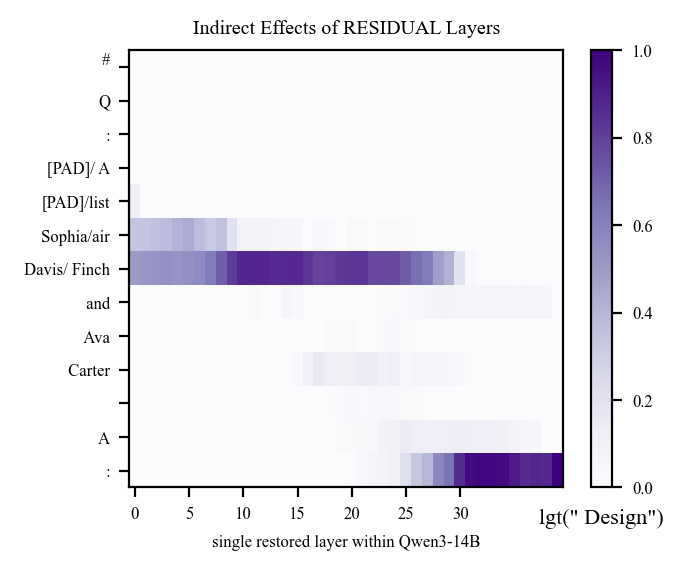

===> trace_start_idx=268
2025-05-15 17:20:08 src.trace DEBUG    answer=PredictedToken(token=' Design', prob=0.54296875, logit=20.5, token_id=6982, metadata=None)
2025-05-15 17:20:08 src.trace DEBUG    clean_answer=PredictedToken(token=' British', prob=0.416015625, logit=19.875, token_id=7855, metadata=None)
2025-05-15 17:20:08 src.trace DEBUG    track_ans=PredictedToken(token=' Design', prob=2.7120113372802734e-06, logit=7.9375, token_id=6982, metadata=None)
2025-05-15 17:20:08 src.trace DEBUG    base_score=20.5 | low_score=7.9375
2025-05-15 17:20:08 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 520/520 [01:15<00:00,  6.86it/s]

2025-05-15 17:21:24 src.trace INFO     base_score=20.5 | low_score=7.9375
2025-05-15 17:21:24 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x78dcd86b2910>
2025-05-15 17:21:24 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-05-15 17:21:24 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:21:24 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:21:24 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


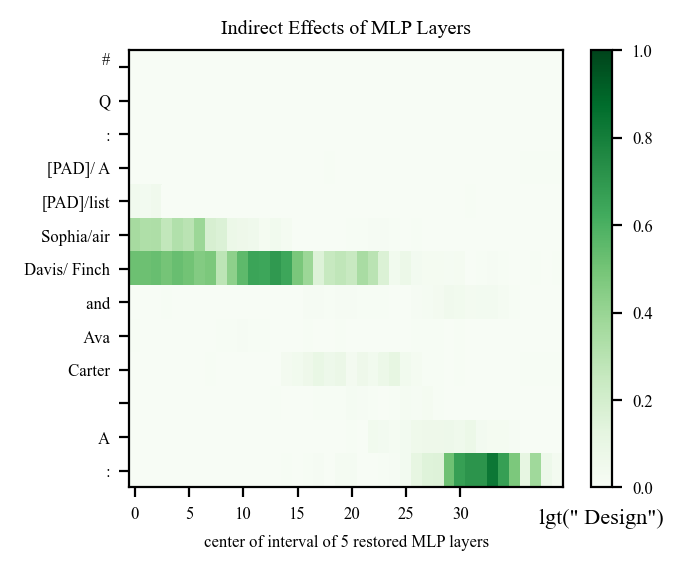

===> trace_start_idx=268
2025-05-15 17:21:24 src.trace DEBUG    answer=PredictedToken(token=' Design', prob=0.54296875, logit=20.5, token_id=6982, metadata=None)
2025-05-15 17:21:24 src.trace DEBUG    clean_answer=PredictedToken(token=' British', prob=0.416015625, logit=19.875, token_id=7855, metadata=None)
2025-05-15 17:21:24 src.trace DEBUG    track_ans=PredictedToken(token=' Design', prob=2.7120113372802734e-06, logit=7.9375, token_id=6982, metadata=None)
2025-05-15 17:21:24 src.trace DEBUG    base_score=20.5 | low_score=7.9375
2025-05-15 17:21:24 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 520/520 [01:16<00:00,  6.79it/s]

2025-05-15 17:22:41 src.trace INFO     base_score=20.5 | low_score=7.9375
2025-05-15 17:22:41 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x78dcd896a390>
2025-05-15 17:22:41 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-05-15 17:22:41 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:22:41 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-05-15 17:22:41 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


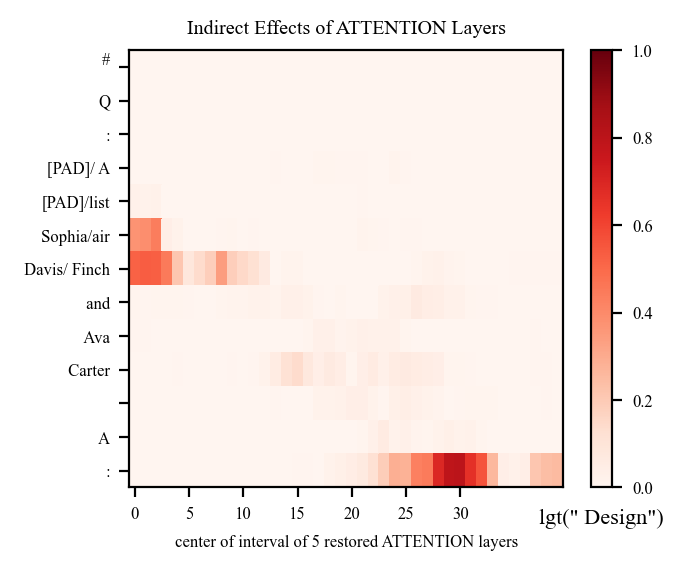

In [63]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
# for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt_check,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        # clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        # patched_input=TokenizerOutput(data=patch_prompt.tokenized),
        trace_start_marker="#",

        metric="logit",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )